In [208]:
# How have Airbnb rental prices changed over time (between 2008 and ?)?
# Which is the cheapest booking available per city and most expensive? VISUALIZATION (line chart, try box+whisker)
## Min (Cheapest)
## Mean (Average)
## Max (Most expensive) 
# Are superhost properties more or less expensive than ones that aren’t? and/or what percentage of airbnb properties are managed by superhosts?
# What is the range of rental prices for each neighborhood and metro area (neighborhood group)?

In [210]:
# import modules
import os
import csv
import pandas as pd
import numpy as np
import scipy.stats as st

# import modules for visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from holoviews import opts

In [212]:
# create an Airbnb dataframe
airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')
airbnb_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_identity_verified,instant_bookable,accommodates,amenities,...,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,27-06-2008,f,t,f,6,"[""Elevator"", ""Cable TV"", ""Air conditioning"", ""...",...,2.0,3.0,115,30,730,2,15-05-2016,0.02,1,216
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,16-09-2008,t,t,t,1,"[""Host greets you"", ""Elevator"", ""Air condition...",...,1.0,1.0,71,30,366,27,6/10/2020,0.35,2,360
2,2732,Zen Life at the Beach,3041,Yoga Priestess,17-09-2008,f,t,f,1,"[""Cooking basics"", ""Host greets you"", ""Smoke a...",...,1.0,1.0,155,1,180,21,27-12-2019,0.18,2,337
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,25-09-2008,f,t,t,2,"[""Host greets you"", ""Air conditioning"", ""Carbo...",...,1.0,1.0,50,30,730,0,NaN,NaN,1,0
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,5/3/2009,t,t,f,2,"[""Lock on bedroom door"", ""Fire extinguisher"", ...",...,1.0,1.0,60,30,1125,310,29-04-2020,2.25,5,337


In [213]:
# identify states
states = airbnb_df['State'].unique()
states

array(['California', 'Illinois', 'Florida', 'Hawaii', 'Nevada',
       'New York ', 'Tennessee', 'DC', 'Washington'], dtype=object)

In [216]:
# get column names list
airbnb_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost',
       'host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'State', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'property_type', 'room_type', 'bathrooms',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

Cleaning Data Tasks

In [219]:
# remove unnecessary columns
clean_airbnb_df = airbnb_df.drop(columns=['host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'latitude', 'longitude','room_type', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count'])

# change column names for clarity
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood_group': 'metro'})
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood':'city'})

# remove host sites where availability is 0/365 days
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['availability_365'] != 0]

# remove hosts sites where price is 0
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['price'] !=0]

# change state names to abbreviations for easy visualization
# create a dictionary mapping state names to abbreviations
state_abbreviations = {
    'California': 'CA',
    'Illinois': 'IL',
    'Florida': 'FL',
    'Hawaii':'HI',
    'Nevada':'NV',
    'New York ':'NY',
    'Tennessee':'TN',
    'DC':'DC',
    'Washington':'WA'
}

# Example list of state names
state_names = ['California', 'Illinois', 'Florida', 'Hawaii', 'Nevada','New York ', 'Tennessee', 'DC', 'Washington']

# Convert state names to abbreviations
states = [state_abbreviations[state] for state in state_names]

# Apply the mapping to the 'State' column
clean_airbnb_df['State Abbreviation'] = clean_airbnb_df['State'].map(state_abbreviations)

# reformat dates
# Ensure 'host_since' is of string type
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].astype(str)

# Now convert to datetime, allowing for multiple formats
# replace '-' with '/' in the 'host_since' column to standardize the format
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].str.replace('-', '/')
clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], dayfirst=False, errors='coerce')
clean_airbnb_df.head()

C:\Users\hmk81\AppData\Local\Temp\ipykernel_13792\4260824999.py:46: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], dayfirst=False, errors='coerce')


,id,name,host_id,host_name,host_since,host_is_superhost,State,metro,city,property_type,price,availability_365,State Abbreviation
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,2008-06-27,f,California,Los Angeles,Culver City,Entire condominium,115,216,CA
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,2008-09-16,t,California,Los Angeles,Hollywood,Private room in apartment,71,360,CA
2,2732,Zen Life at the Beach,3041,Yoga Priestess,2008-09-17,f,California,Los Angeles,Santa Monica,Private room in apartment,155,337,CA
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,2009-03-05,t,California,Los Angeles,Del Rey,Private room in tiny house,60,337,CA
5,5729,Zen Room with Floating Bed near Venice and LAX,9171,Sanni,2009-03-05,t,California,Los Angeles,Del Rey,Private room in guesthouse,70,332,CA


In [221]:
# identify metro areas represented in the data
metro_areas = clean_airbnb_df["metro"].unique()
metro_areas

array(['Los Angeles', 'San Diego County', 'San Francisco', 'San Mateo',
       'Saint Clara County', ' Santa Cruz', 'Chicago', 'Broward County',
       'Hawaii', 'Kauai', 'Maui', 'Honolulu', 'Clark County', 'Manhattan',
       'Brooklyn', 'Queens', 'Staten Island', 'Bronx', 'Nashville',
       'Washington D.C', 'Seattle'], dtype=object)

In [223]:
# summary statistics for Airbnb prices
clean_airbnb_df["price"].describe()

count    127877.000000
mean        209.163008
std         436.704186
min          10.000000
25%          79.000000
50%         125.000000
75%         209.000000
max       24999.000000
Name: price, dtype: float64

In [183]:
# average prices for each city/county (some are counties, some are cities)
# median chosen because there seemed to be some big outliers
median_prices = clean_airbnb_df.groupby('metro')['price'].median().round(2).sort_values(ascending=True)
median_prices

metro
Bronx                  68.0
Queens                 70.0
Staten Island          76.0
Brooklyn               95.0
Chicago                99.0
Saint Clara County     99.0
Seattle               107.0
Washington D.C        108.0
Los Angeles           117.0
San Mateo             120.0
Manhattan             120.0
Broward County        120.0
San Francisco         129.0
Clark County          129.0
San Diego County      140.0
Honolulu              145.0
Nashville             150.0
Hawaii                150.0
Maui                  225.0
 Santa Cruz           225.0
Kauai                 239.0
Name: price, dtype: float64

In [185]:
# max values for each metro area
max_prices = clean_airbnb_df.groupby("metro")['price'].max().round(2).sort_values(ascending=True)
max_prices

metro
Staten Island          1200
Bronx                  2000
 Santa Cruz            3250
Seattle                3503
Brooklyn               4000
Kauai                  4200
Nashville              5000
San Mateo             10000
San Francisco         10000
Saint Clara County    10000
Queens                10000
Manhattan             10000
Clark County          10000
Chicago               10000
Broward County        10000
Washington D.C        10000
Hawaii                15000
Los Angeles           21053
Honolulu              24600
San Diego County      24999
Maui                  24999
Name: price, dtype: int64

In [187]:
# min values for each metro area
min_prices = clean_airbnb_df.groupby('metro')['price'].min().round(2).sort_values(ascending=True)
min_prices

metro
Washington D.C        10
Brooklyn              10
Chicago               10
Honolulu              10
Los Angeles           10
San Francisco         10
Nashville             10
Queens                10
Saint Clara County    11
Broward County        12
Clark County          13
San Diego County      13
Hawaii                15
Seattle               16
San Mateo             19
Manhattan             19
Bronx                 20
Maui                  20
Staten Island         22
 Santa Cruz           30
Kauai                 49
Name: price, dtype: int64

In [189]:
# find new york only locations
ny_locations = clean_airbnb_df.loc[clean_airbnb_df['State Abbreviation'] == 'NY']
ny_locations

,id,name,host_id,host_name,host_since,host_is_superhost,State,metro,city,property_type,price,availability_365,State Abbreviation
103641,2595,Skylit Midtown Castle,2845,Jennifer,2008-09-09,f,New York,Manhattan,Midtown,Entire apartment,175,365,NY
103642,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,2008-12-07,f,New York,Brooklyn,Clinton Hill,Entire guest suite,74,307,NY
103643,5121,BlissArtsSpace!,7356,Garon,2009-02-03,f,New York,Brooklyn,Bedford-Stuyvesant,Private room in apartment,60,365,NY
103646,5803,"Lovely Room 1, Garden, Best Area, Legal rental",9744,Laurie,2009-03-10,t,New York,Brooklyn,South Slope,Private room in townhouse,89,365,NY
103647,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,2009-05-06,f,New York,Brooklyn,Williamsburg,Entire apartment,109,253,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140559,46937371,Gramercy Loft-Studio/Prime Location ~W&D in unit~,27181542,Jt,2015-02-03,f,New York,Manhattan,Kips Bay,Entire apartment,199,180,NY
140560,46937954,Upper West Side Penthouse- Terrace & Hidden Ga...,287807769,Allen,2019-08-21,f,New York,Manhattan,Upper West Side,Entire apartment,205,83,NY
140561,46938514,Cozy shared room in East Harlem,303319010,Naiomy,2019-10-19,t,New York,Manhattan,East Harlem,Shared room in apartment,35,176,NY
140562,46938537,Boho Chic Rhapsody in New York City,3351317,Clara,2012-08-23,f,New York,Manhattan,Kips Bay,Entire apartment,295,83,NY


In [191]:
# Create a data frame showing mean, min, max for each city
# Group by 'neighbourhood_group' and calculate mean, min, and max prices
metro_price_stats_df = pd.DataFrame(clean_airbnb_df.groupby(['metro', 'State Abbreviation'])['price'].agg(['median', 'min', 'max']))

# Reset the index to turn the grouped index into a column
metro_price_stats_df = metro_price_stats_df.reset_index()

# Rename the columns for clarity
metro_price_stats_df.columns = ['Metro Area', 'State Abbreviation', 'Median Price', 'Min Price', 'Max Price']

# First, sort the DataFrame by the 'State Abbreviation' column
metro_price_stats_df = metro_price_stats_df.sort_values(by='State Abbreviation', ascending=True)

# Modify the 'Metro Area' column to include the state name after the city name
metro_price_stats_df['Metro Area'] = metro_price_stats_df['Metro Area'] + ', ' + metro_price_stats_df['State Abbreviation']

# Drop the 'State' column
# metro_price_stats_df = metro_price_stats_df.drop(columns=['State Abbreviation'])

# Sort values by mean
# metro_price_stats_df = metro_price_stats.sort_values(by='Median Price', ascending=True)

# Display the resulting DataFrame
metro_price_stats_df

,Metro Area,State Abbreviation,Median Price,Min Price,Max Price
0,"Santa Cruz, CA",CA,225.0,30,3250
17,"San Mateo, CA",CA,120.0,19,10000
16,"San Francisco, CA",CA,129.0,10,10000
15,"San Diego County, CA",CA,140.0,13,24999
14,"Saint Clara County, CA",CA,99.0,11,10000
9,"Los Angeles, CA",CA,117.0,10,21053
20,"Washington D.C, DC",DC,108.0,10,10000
3,"Broward County, FL",FL,120.0,12,10000
7,"Honolulu, HI",HI,145.0,10,24600
8,"Kauai, HI",HI,239.0,49,4200


Median Prices per Metro Area

In [194]:
# Take out 0 values from min price?
# worth sorting by median price?
# in original data frame, change state to abbreviation (formula for that?)

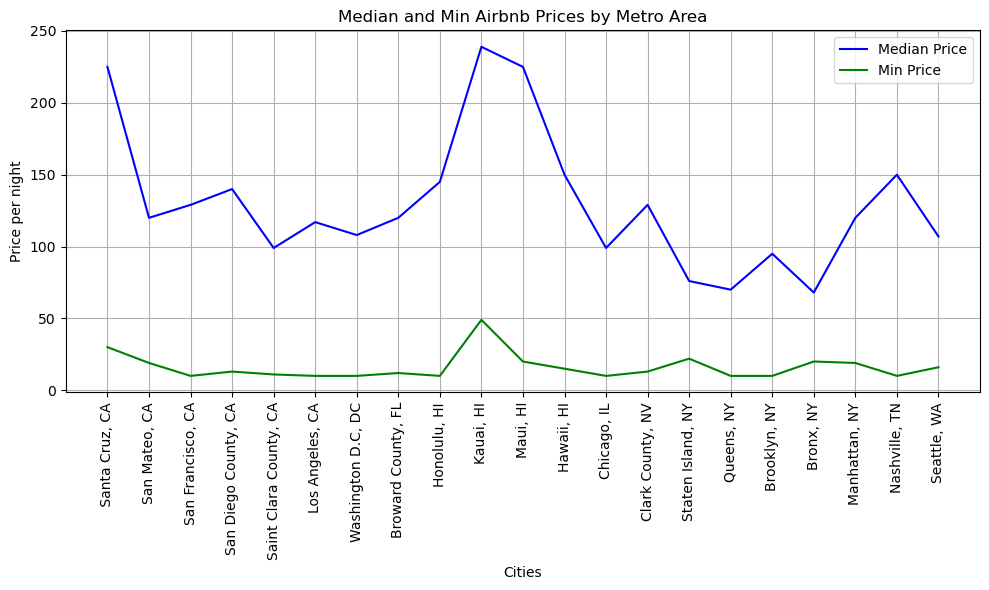

In [196]:
# create line graphs showing mean, min, and max prices for each city

# Extract the cities and corresponding prices
cities = metro_price_stats_df['Metro Area']
median_prices = metro_price_stats_df['Median Price']
min_prices = metro_price_stats_df['Min Price']
# max_prices = metro_price_stats_df['Max Price']

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(cities, median_prices, color="blue", label="Median Price")
plt.plot(cities, min_prices, color="green", label="Min Price")
# plt.plot(cities, max_prices, color="red", label="Max Price")

# Add titles and labels
plt.title("Median and Min Airbnb Prices by Metro Area")
plt.xlabel("Cities")
plt.ylabel("Price per night")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid()

# Save plot as image file
plt.savefig("output_data/Fig3a.png")

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

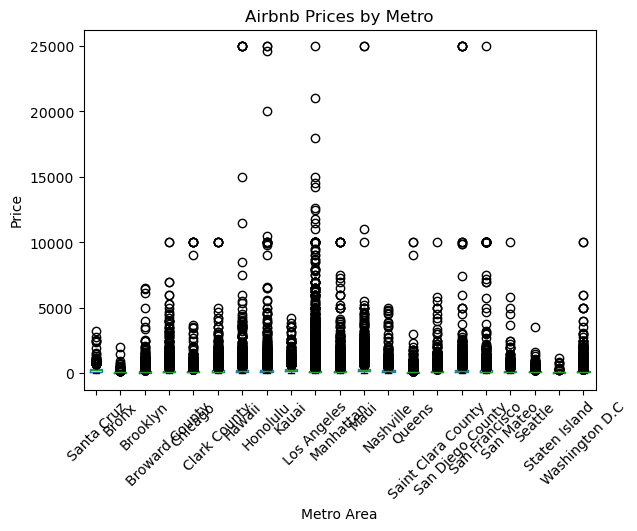

In [197]:

plt.figure(figsize=(12, 6))
airbnb_df.boxplot(column='price', by='neighbourhood_group', grid=False)

plt.title('Airbnb Prices by Metro')
plt.suptitle('')  # Suppress the default title to make it cleaner
plt.xlabel('Metro Area')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x labels for better readability

# Save plot as image file
plt.savefig("output_data/Fig3b.png")

plt.show()

In [198]:
# For max values, identify the host_id/name - is it a hotel?

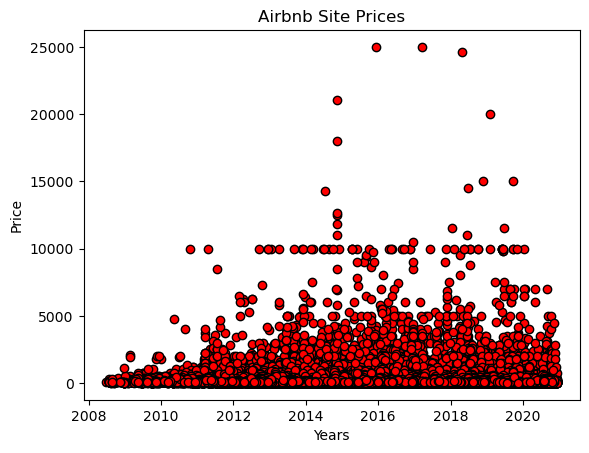

In [202]:
# price change over time (2008 to present)
clean_airbnb_df['host_since']

# scatter plot price 2008 to present
x_axis = clean_airbnb_df['host_since']
y_axis = clean_airbnb_df['price']
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Airbnb Site Prices') 

plt.scatter(x_axis, y_axis, marker="o", facecolors="red", edgecolors = "black")

plt.show()

In [ ]:
# Are superhost properties more or less expensive than ones that aren’t? and/or what percentage of airbnb properties are managed by superhosts?

In [ ]:
# What is the range of rental prices for each neighborhood and metro area (neighborhood group)?